# PyDMD

## User Manual 1: BOP-DMD on Flow Past a Cylinder Data

In this guide, we briefly highlight all of the major features of the `BOPDMD`[[docs]](https://pydmd.github.io/PyDMD/bopdmd.html)[[source]](https://github.com/PyDMD/PyDMD/blob/master/pydmd/bopdmd.py) module by applying it to 2-D flow past a cylinder vorticity data with Reynolds number $Re = 100$. Examples listed in the table of contents will consecutively build on one another so that sample models will slowly increase in complexity. Data is available at <ins>dmdbook.com/DATA.zip</ins>. Note that we use a low resolution version of the data in this guide.

#### Table of Contents:
1. [Optimized DMD](#optdmd)
2. [Optimized DMD with Bagging (BOP-DMD)](#bopdmd)
3. [BOP-DMD with Eigenvalue Constraints](#eig)
4. [Using Verbose Outputs](#verbose)
5. [Removing Bad Bags](#bag-fail)
6. [Applying Data Preprocessors](#preprocess)

### Import the Latest Version of PyDMD
To ensure that you are working with the most up-to-date version of PyDMD, clone the repository with
```bash
git clone https://github.com/PyDMD/PyDMD
```
and pip install the package in development mode from the cloned directory.
```bash
pip install -e .
```
We may then perform our imports and be certain to have access to the latest PyDMD features.

In [1]:
import warnings
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

from pydmd import BOPDMD
from pydmd.plotter import plot_summary
from pydmd.preprocessing import zero_mean_preprocessing

warnings.filterwarnings("ignore")

### Import the Flow Past a Cylinder Data
We have 151 snapshots, each with a pixel dimension of 149 x 66. To perform BOP-DMD, we define:
- `X` = (9834, 151) NumPy array of flattened snapshots. We add Gaussian noise for added realism.
- `t` = (151,) NumPy array of times of snapshot collection. We assume these times to be $0,1,\dots$

In [2]:
# Import vorticity data and frame dimensions.
mat = sio.loadmat("CYLINDER_ALL_LOW_RES.mat")

X = mat["VORTALL"]  # Vorticity data.
nx = mat["nx"][0][0]  # Number of pixels along x-axis.
ny = mat["ny"][0][0]  # Number of pixels along y-axis.
m = X.shape[-1]  # Number of time points.
t = np.arange(m)  # Time data.

# Add Gaussian noise to the data.
noise_magnitude = 0.4
rng = np.random.default_rng(seed=1234)
noise = noise_magnitude * rng.standard_normal(X.shape)
X += noise

print(f"Data dimensions = {X.shape} (space, time)")

Data dimensions = (9834, 151) (space, time)


### 1. Optimized DMD
<a id='optdmd'></a>
To perform [Optimized DMD](https://doi.org/10.1137/M1124176), use the `BOPDMD` module with `num_trials=0`.
- Adjust the `svd_rank` parameter to control the number of spatiotemporal modes computed.
- Fit the model with the `fit` function.
    - For the `BOPDMD` module, this function requires both the snapshots `X` and the times `t`.
- Plot results using the `plot_summary` function.
    - See plotting tool documentation [[docs]](https://pydmd.github.io/PyDMD/plotter.html) for more information on customization options.

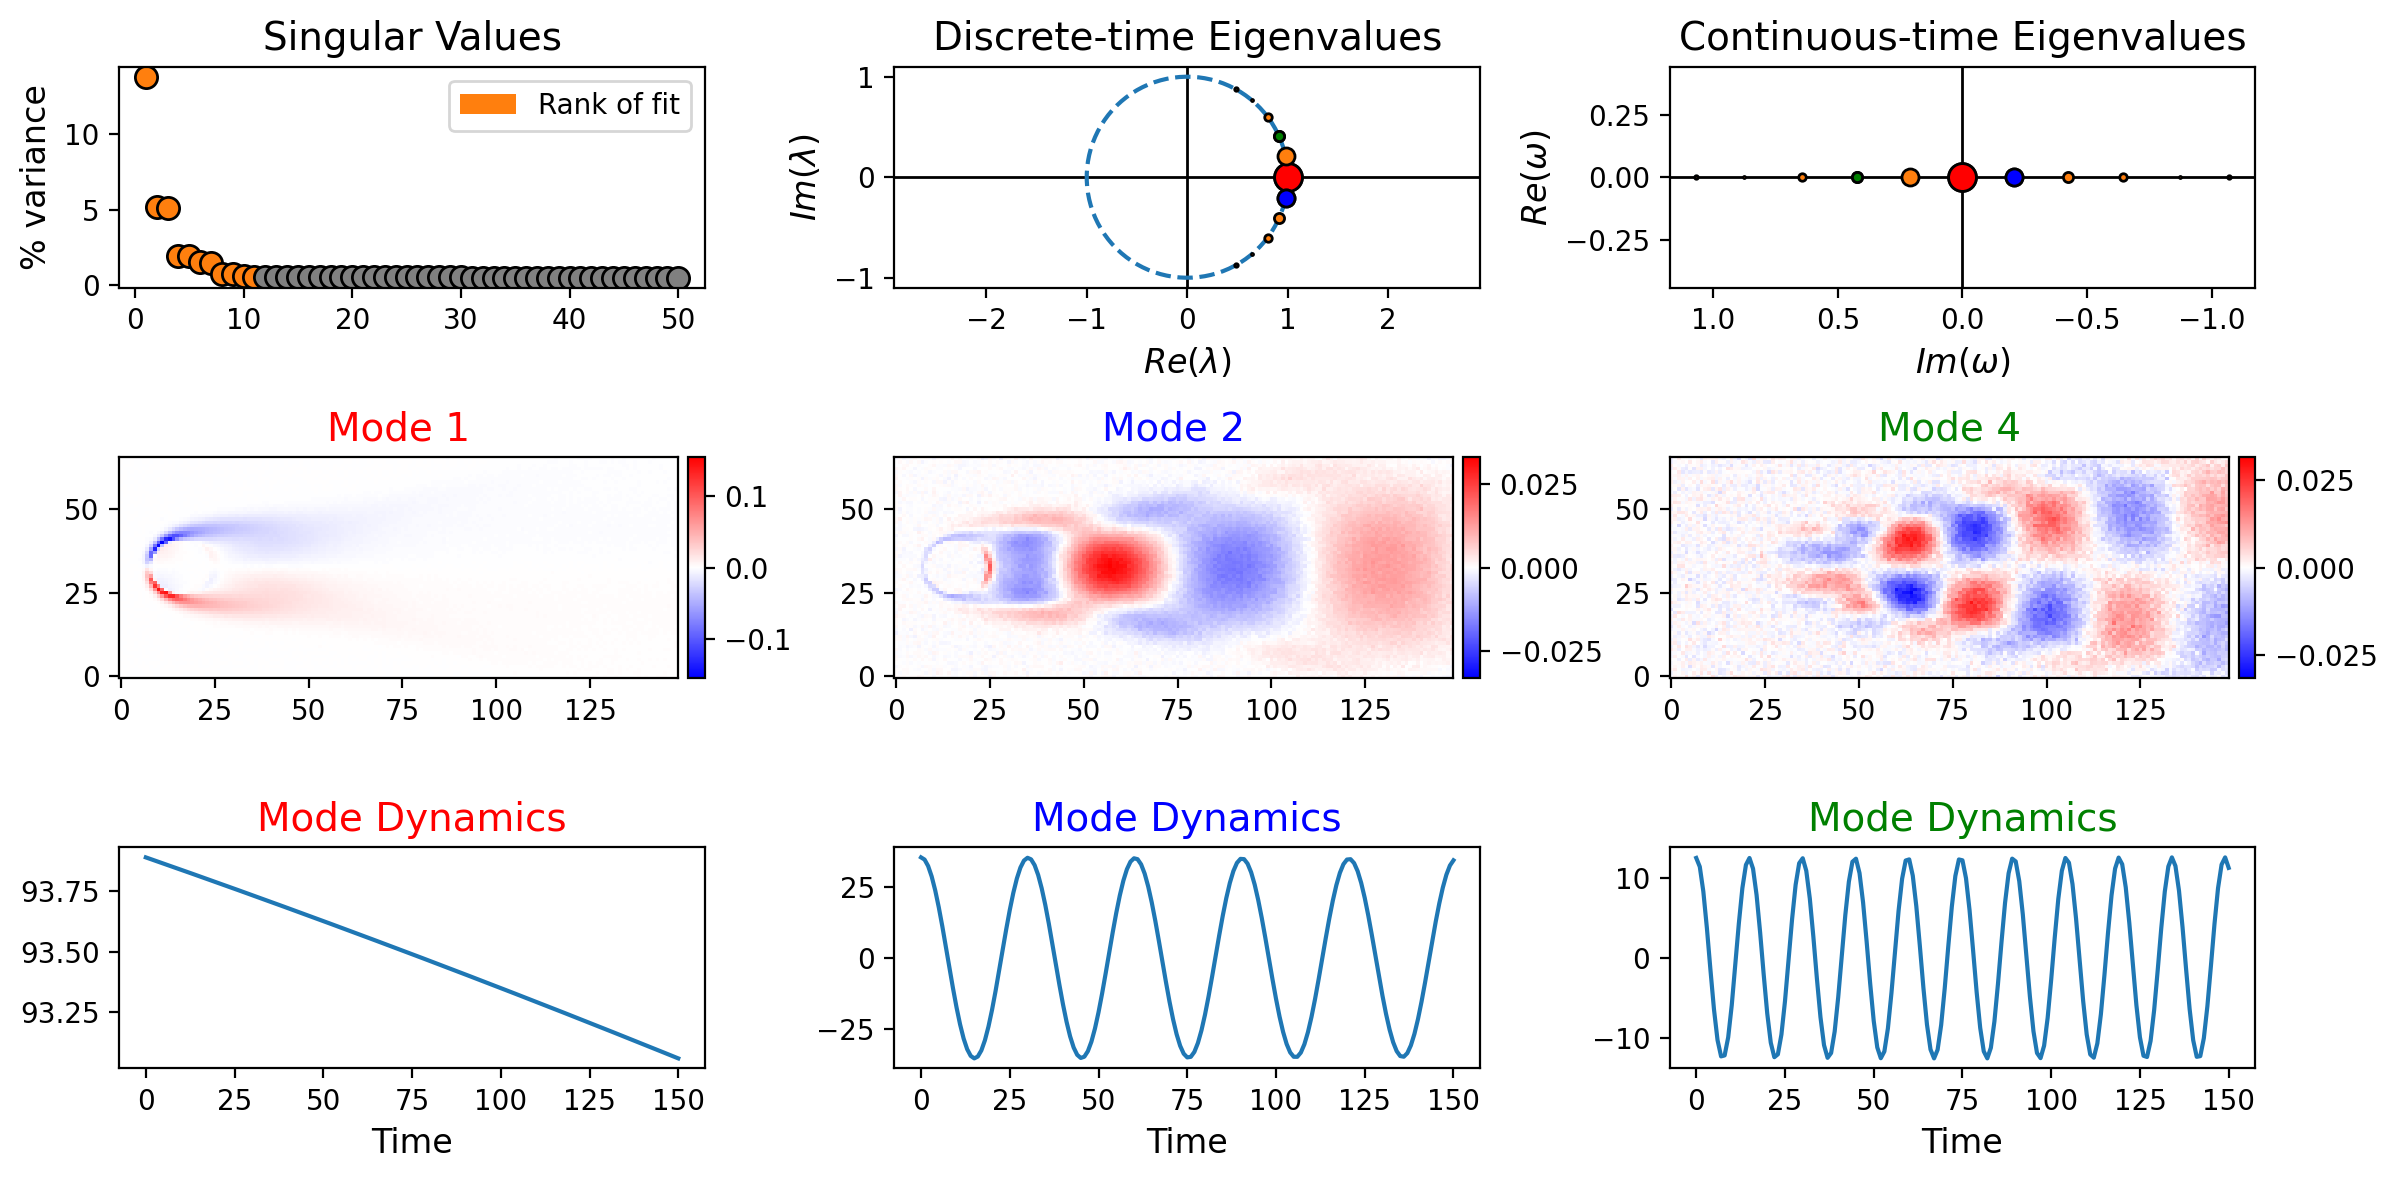

In [3]:
# Build an Optimized DMD model with 11 spatiotemporal modes.
bopdmd = BOPDMD(svd_rank=11, num_trials=0)

# Fit the Optimized DMD model.
bopdmd.fit(X, t)

# Plot a summary of the key spatiotemporal modes.
plot_summary(
    bopdmd,
    figsize=(12, 6),  # Figure size.
    index_modes=(0, 1, 3),  # Indices of the modes to plot.
    snapshots_shape=(ny, nx),  # Shape of the modes.
    order="F",  # Order to use when reshaping the modes.
    flip_continuous_axes=True,  # Rotate the continuous-time eig plot.
)

In [4]:
# Set the plot_summary arguments for later function calls.
plot_summary_kwargs = {}
plot_summary_kwargs["figsize"] = (12, 6)
plot_summary_kwargs["index_modes"] = (0, 1, 3)
plot_summary_kwargs["snapshots_shape"] = (ny, nx)
plot_summary_kwargs["order"] = "F"
plot_summary_kwargs["flip_continuous_axes"] = True

### 2. Optimized DMD with Bagging (BOP-DMD)
<a id='bopdmd'></a>
To perform [BOP-DMD](https://doi.org/10.1098/rsta.2021.0199), use the `BOPDMD` module with `num_trials=k` for positive integer `k`.
- Set the `trial_size` parameter to control the amount of data to use per bag.
- `plot_summary` now displays the average spatiotemporal modes across trials.
- When multiple trials are performed, UQ metrics can also be plotted:
    - Use `plot_eig_uq` for eigenvalue UQ metrics.
    - Use `plot_mode_uq` for mode UQ metrics.

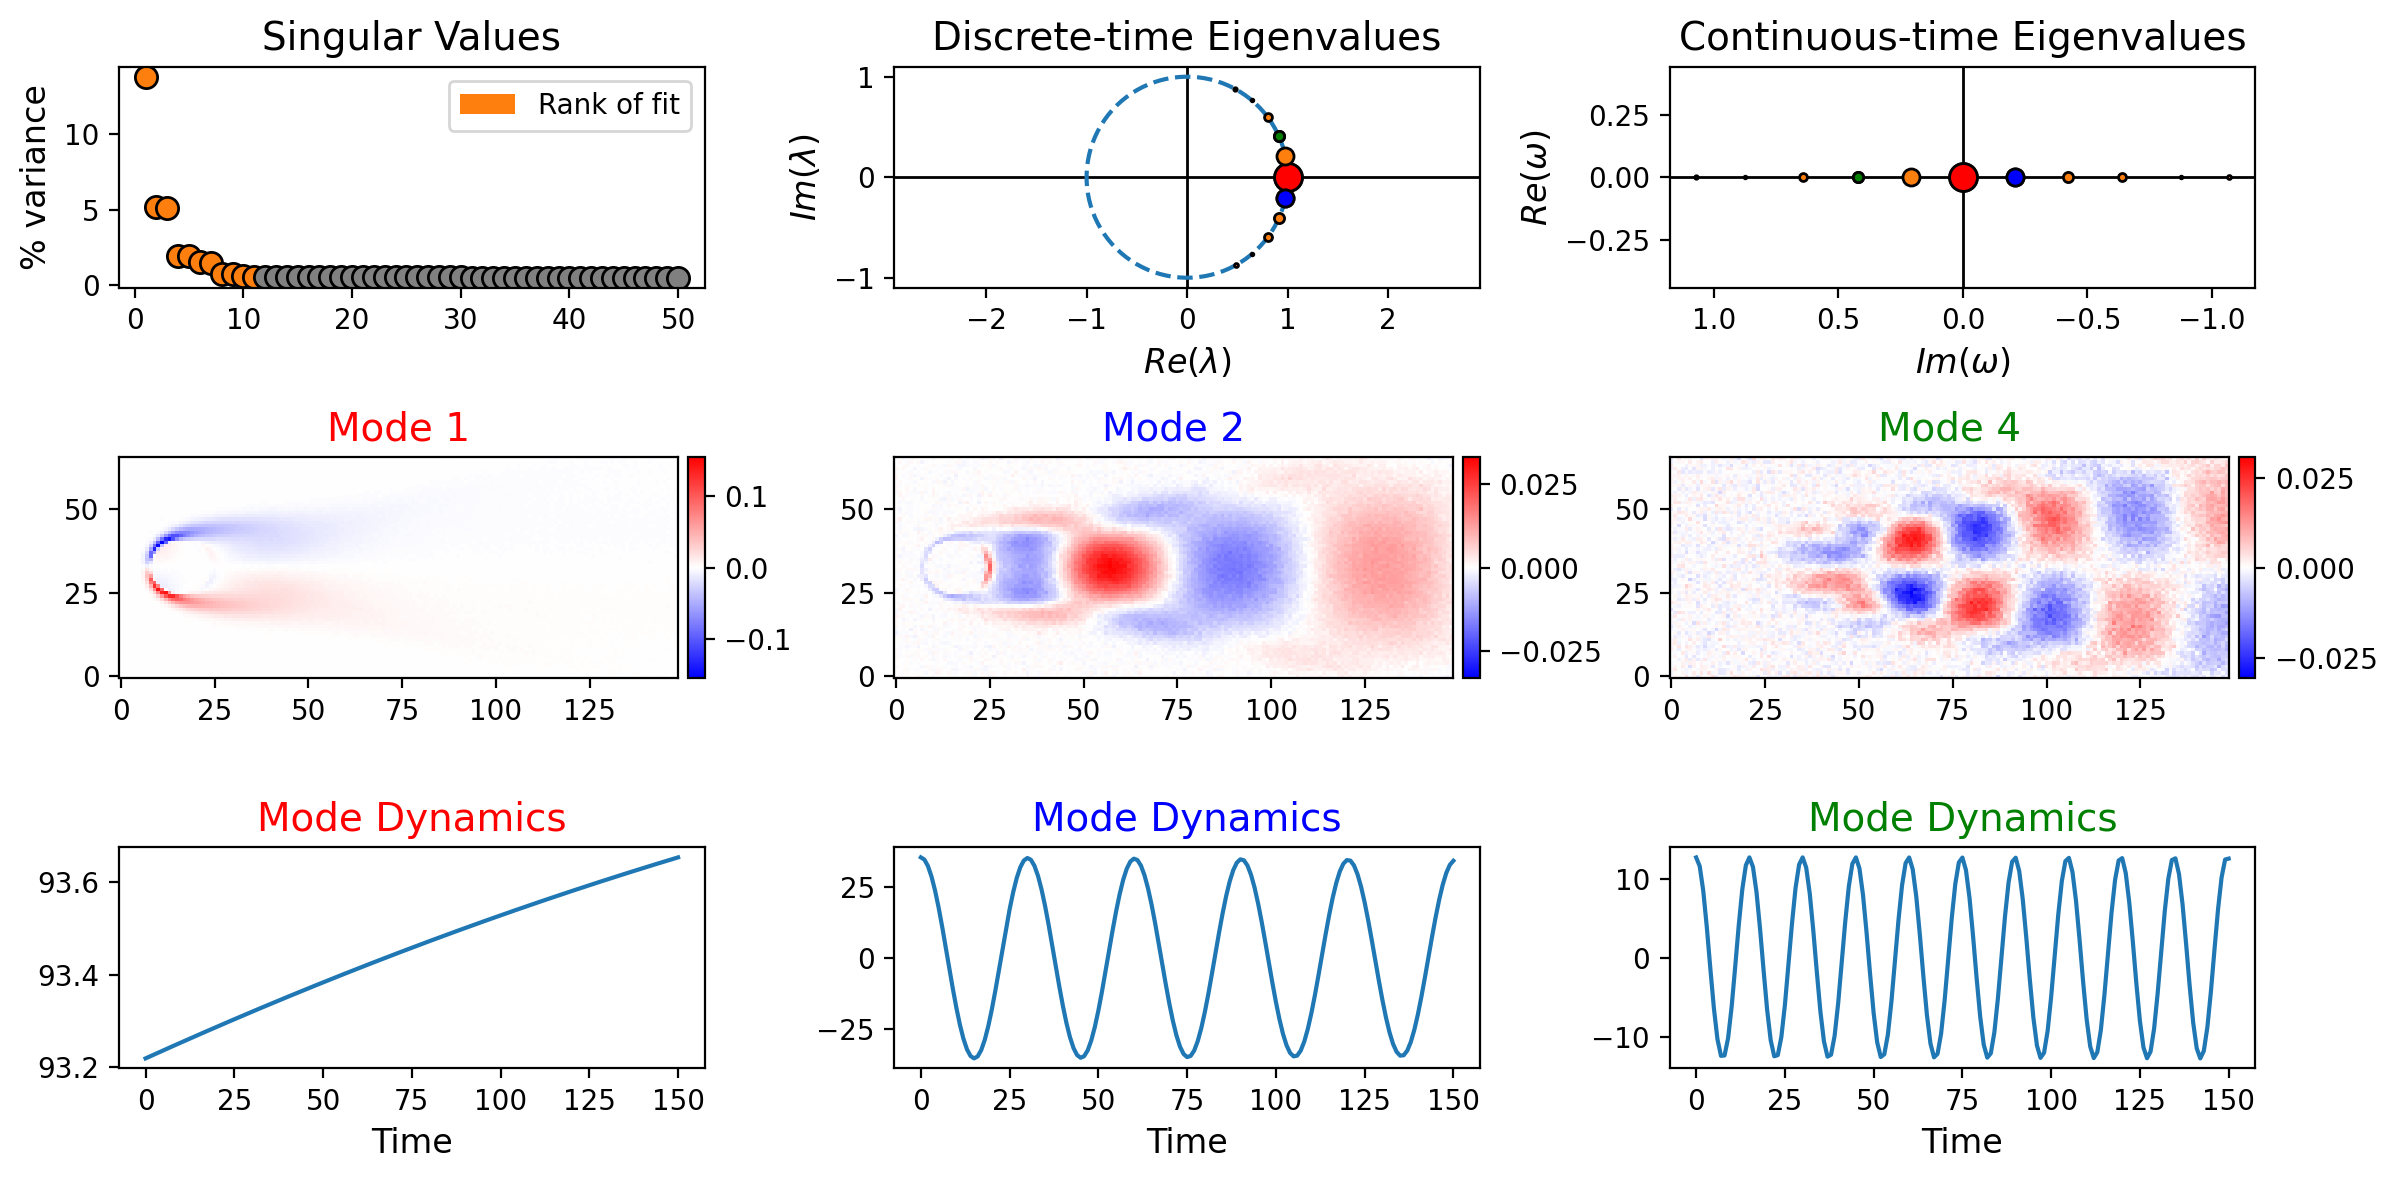

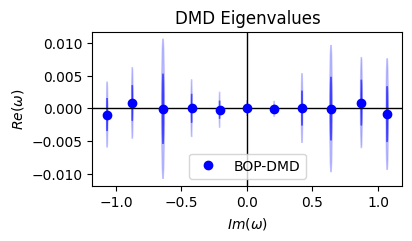

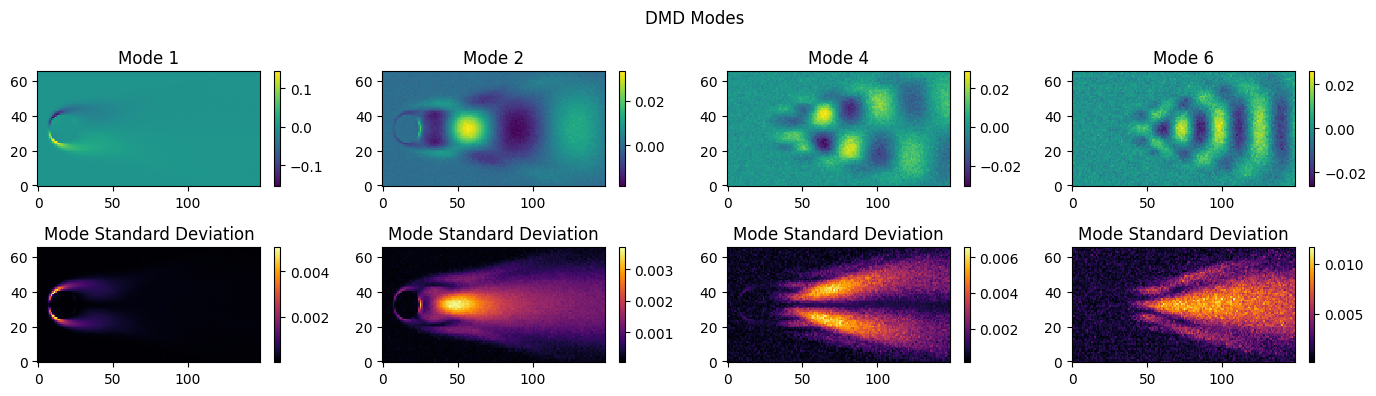

In [5]:
# Build a BOP-DMD model with 11 spatiotemporal modes, and 100 bagging trials,
# where each trial uses 80% of the total number of snapshots per trial.
bopdmd = BOPDMD(svd_rank=11, num_trials=100, trial_size=0.8)
bopdmd.fit(X, t)
plot_summary(bopdmd, **plot_summary_kwargs)

# Plot eigenvalue UQ metrics.
bopdmd.plot_eig_uq(figsize=(4, 2), flip_axes=True, draw_axes=True)

# Plot mode UQ metrics.
bopdmd.plot_mode_uq(
    figsize=(14, 4),
    plot_modes=(0, 1, 3, 5),
    modes_shape=(ny, nx),
    order="F",
)

### 3. BOP-DMD with Eigenvalue Constraints
<a id='eig'></a>
Set the `eig_constraints` parameter to constrain the eigenvalue structure.
- Can be a set of preset constraints, which may be combined:
    - `"stable"` = constrain eigenvalues to the left half of the complex plane.
    - `"imag"` = constrain eigenvalues to the imaginary axis of the complex plane.
    - `"conjugate_pairs"` = eigenvalues must be present with their complex conjugate.
- Can also be a custom function that will be applied to the eigenvalues.

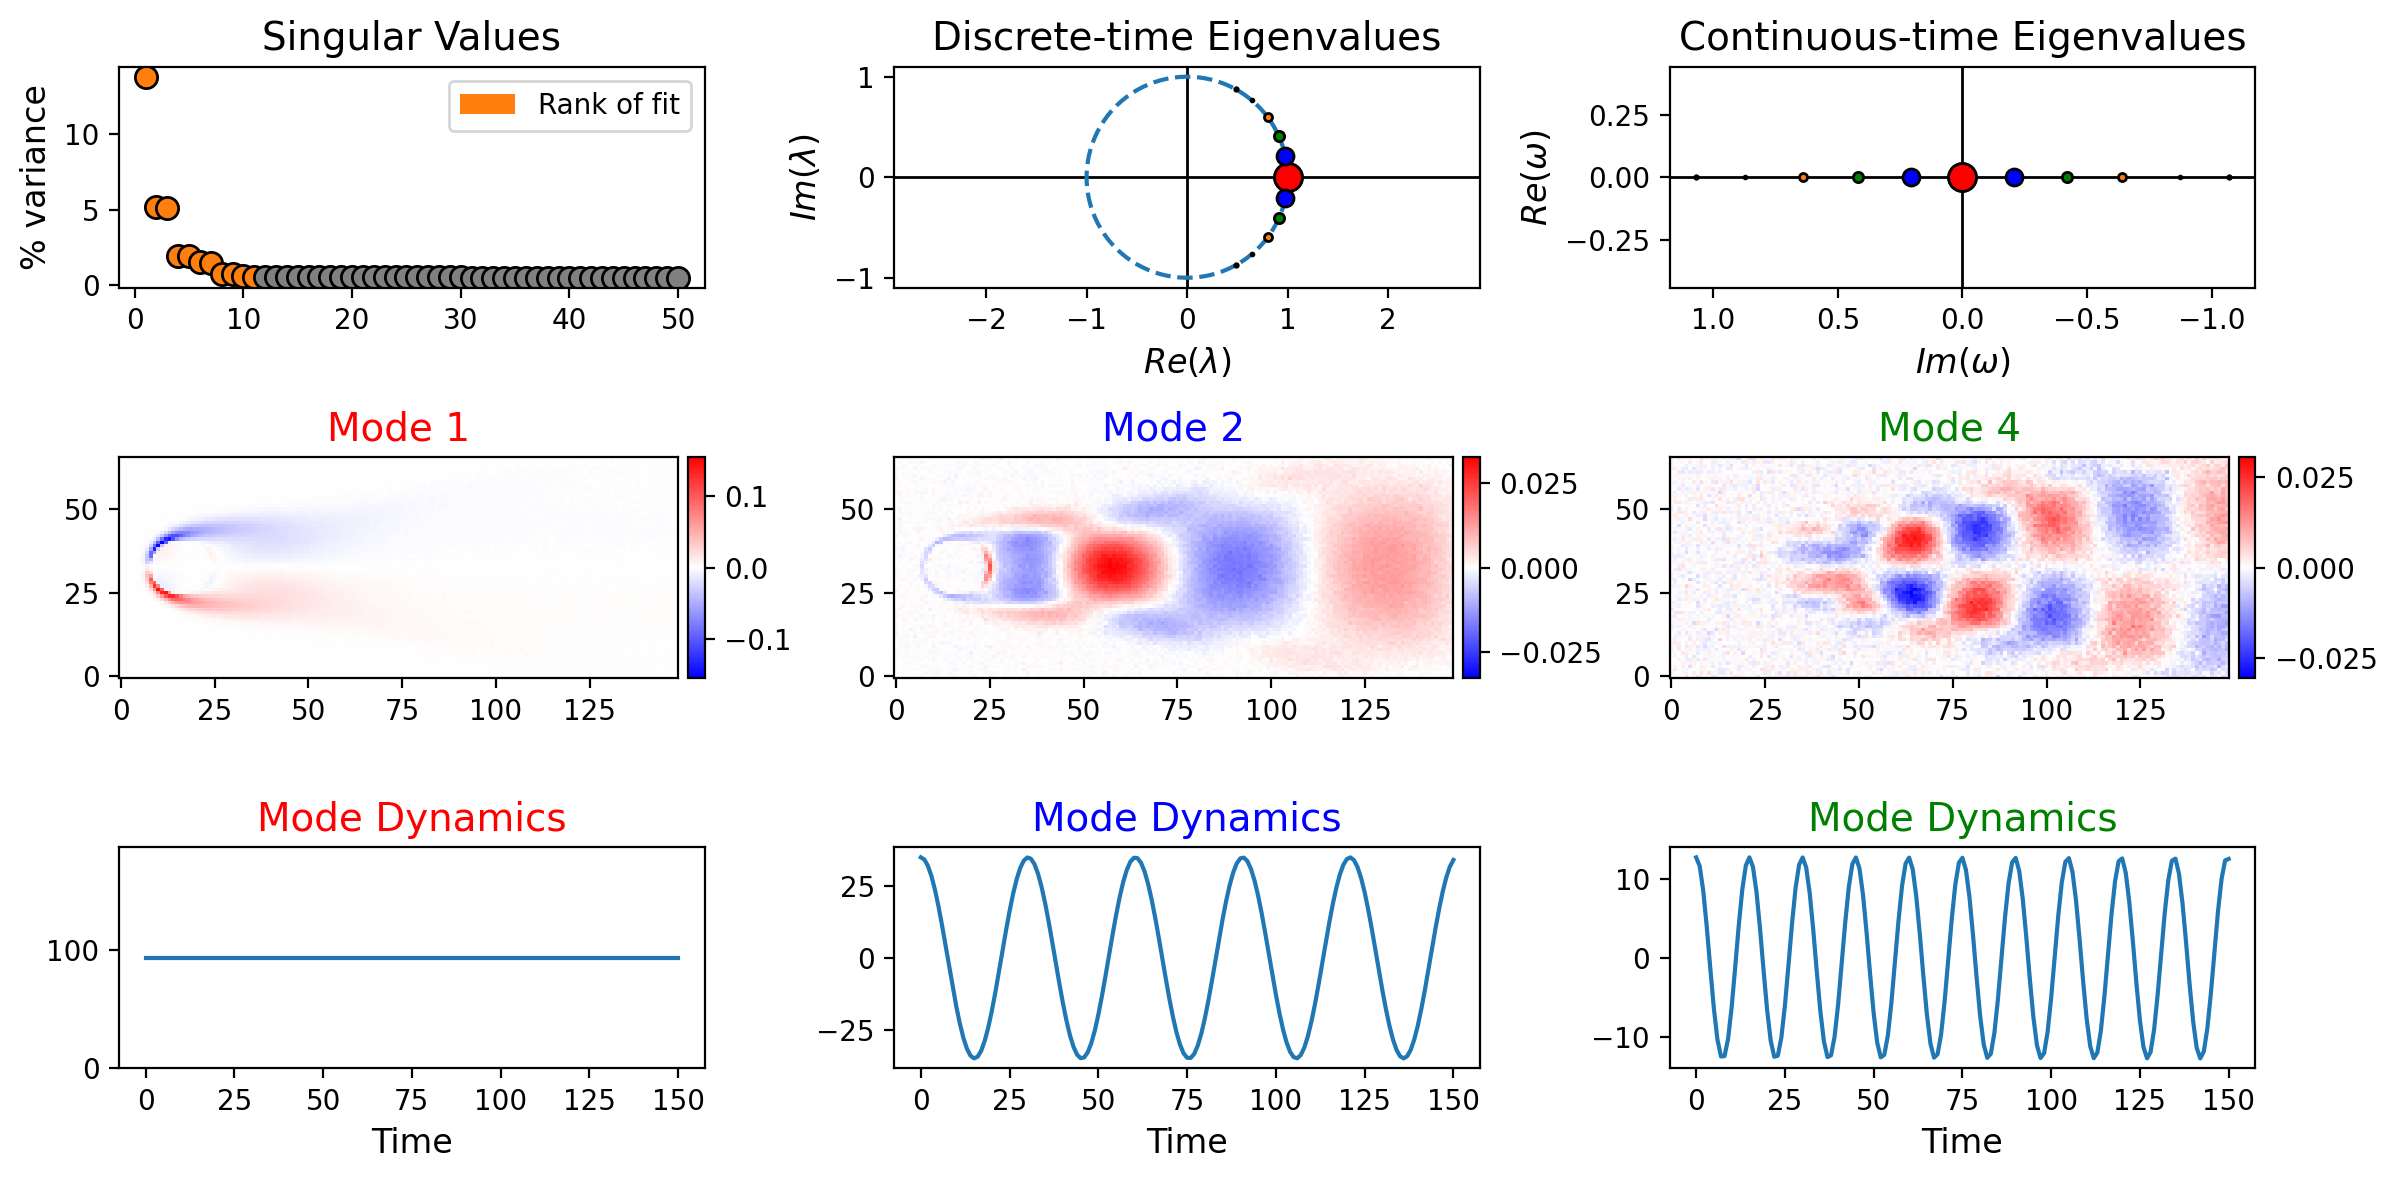

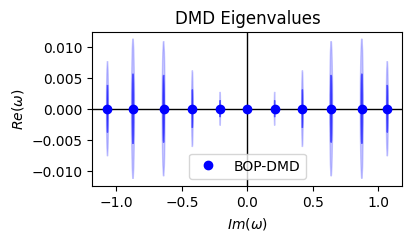

In [6]:
bopdmd = BOPDMD(
    svd_rank=11,
    num_trials=100,
    trial_size=0.8,
    # Constrain the eigenvalues to be imaginary
    # AND to always come in complex conjugate pairs.
    eig_constraints={"imag", "conjugate_pairs"},
)
bopdmd.fit(X, t)
plot_summary(bopdmd, **plot_summary_kwargs)

# View the eigenvalue UQ metrics for comparison.
bopdmd.plot_eig_uq(figsize=(4, 2), flip_axes=True, draw_axes=True)

### 4. Using Verbose Outputs
<a id='verbose'></a>
Turn on verbosity with the `varpro_opts_dict` parameter.
- Verbosity allows users to see the iterative progress of the variable projection routine.
- Verbosity also allows users to see the convergence status of the first 5 bagging trials.
- See the `BOPDMDOperator` documentation [[docs]](https://pydmd.github.io/PyDMD/bopdmd.html) for more information on all of the parameters that can be set with the `varpro_opts_dict`.

In [7]:
bopdmd = BOPDMD(
    svd_rank=11,
    num_trials=100,
    trial_size=0.8,
    eig_constraints={"imag", "conjugate_pairs"},
    # Turn on verbosity.
    varpro_opts_dict={"verbose": True},
)
bopdmd.fit(X, t)

Failed to find appropriate step length at iteration 1. Current error 0.13906306026866166. Consider increasing maxlam or lamup.

Displaying the results of the next 5 trials...

Using all bag trial results...

Step 1 Error 0.13244455630074936 Lambda 1024.0
Failed to find appropriate step length at iteration 2. Current error 0.13244455630074936. Consider increasing maxlam or lamup.

Step 1 Error 0.13519757993825027 Lambda 68719476736.0
Failed to find appropriate step length at iteration 2. Current error 0.13519757993825027. Consider increasing maxlam or lamup.

Step 1 Error 0.1351956880705897 Lambda 68719476736.0
Step 2 Error 0.13519568807058957 Lambda 22906492245.333332
Stall detected: error reduced by less than 1e-12 times the error at the previous step. Iteration 2. Current error 0.13519568807058957. Consider increasing tol or decreasing eps_stall.

Step 1 Error 0.13702110016062208 Lambda 68719476736.0
Step 2 Error 0.13702110016062205 Lambda 1382597929613.0217
Stall detected: error red

### 5. Removing Bad Bags
<a id='bag-fail'></a>
Omit the results of non-converged trials by setting `remove_bad_bags=True` (defaults to `False`).
- Doing this activates the parameters `bag_warning` and `bag_maxfail`:
    - `bag_warning` = number of consecutive non-converged trials at which to warn the user. (default=100)
    - `bag_maxfail` = number of consecutive non-converged trials to tolerate before quitting. (default=200)
    - Use negative integer arguments for no warning or stopping condition.
- Whether or not a trial converges depends on the tolerance parameter, which is controlled by `tol`.
    - Set this parameter with the `varpro_opts_dict`.
    - Use verbosity to gauge what a realistic tolerance might look like for your data.

In [8]:
bopdmd = BOPDMD(
    svd_rank=11,
    num_trials=100,
    trial_size=0.8,
    eig_constraints={"imag", "conjugate_pairs"},
    # Adjust the tolerance so that convergence is more reasonable.
    varpro_opts_dict={"verbose": True, "tol": 0.12},
    # BOP-DMD will run until 100 trials converge,
    # OR until 200 consecutive trials fail to converge.
    remove_bad_bags=True,
)
bopdmd.fit(X, t)

Failed to find appropriate step length at iteration 1. Current error 0.13906306026866166. Consider increasing maxlam or lamup.

Displaying the results of the next 5 trials...

Non-converged trial results will be removed...

Step 1 Error 0.13417617823070174 Lambda 2048.0
Step 2 Error 0.11201655974044106 Lambda 682.6666666666666
Convergence reached!

Step 1 Error 0.13723674230168942 Lambda 16384.0
Failed to find appropriate step length at iteration 2. Current error 0.13723674230168942. Consider increasing maxlam or lamup.

Step 1 Error 0.13445617594967066 Lambda 512.0
Step 2 Error 0.1344561759496706 Lambda 68719476736.0
Stall detected: error reduced by less than 1e-12 times the error at the previous step. Iteration 2. Current error 0.1344561759496706. Consider increasing tol or decreasing eps_stall.

Failed to find appropriate step length at iteration 1. Current error 0.13801871733258567. Consider increasing maxlam or lamup.

Step 1 Error 0.1343187507138831 Lambda 4096.0
Failed to find a

### 6. Applying Data Preprocessors
<a id='preprocess'></a>
`BOPDMD` models can be used with tools from the `pydmd.preprocessing` suite.
- Simply wrap your `BOPDMD` model with the desired preprocessing tool.
- Calls to `fit` will now require setting the time vector `t` with a keyword argument.

Step 1 Error 0.20942315969567515 Lambda 0.3333333333333333
Failed to find appropriate step length at iteration 2. Current error 0.20942315969567515. Consider increasing maxlam or lamup.

Displaying the results of the next 5 trials...

Non-converged trial results will be removed...

Step 1 Error 0.2044279552605657 Lambda 4096.0
Step 2 Error 0.20420924870235801 Lambda 8192.0
Step 3 Error 0.1950891049139436 Lambda 2730.6666666666665
Convergence reached!

Step 1 Error 0.20909620358077077 Lambda 16384.0
Failed to find appropriate step length at iteration 2. Current error 0.20909620358077077. Consider increasing maxlam or lamup.

Step 1 Error 0.1926844205920879 Lambda 2048.0
Convergence reached!

Step 1 Error 0.1957605449752934 Lambda 4096.0
Convergence reached!

Step 1 Error 0.1959278906731956 Lambda 4096.0
Convergence reached!



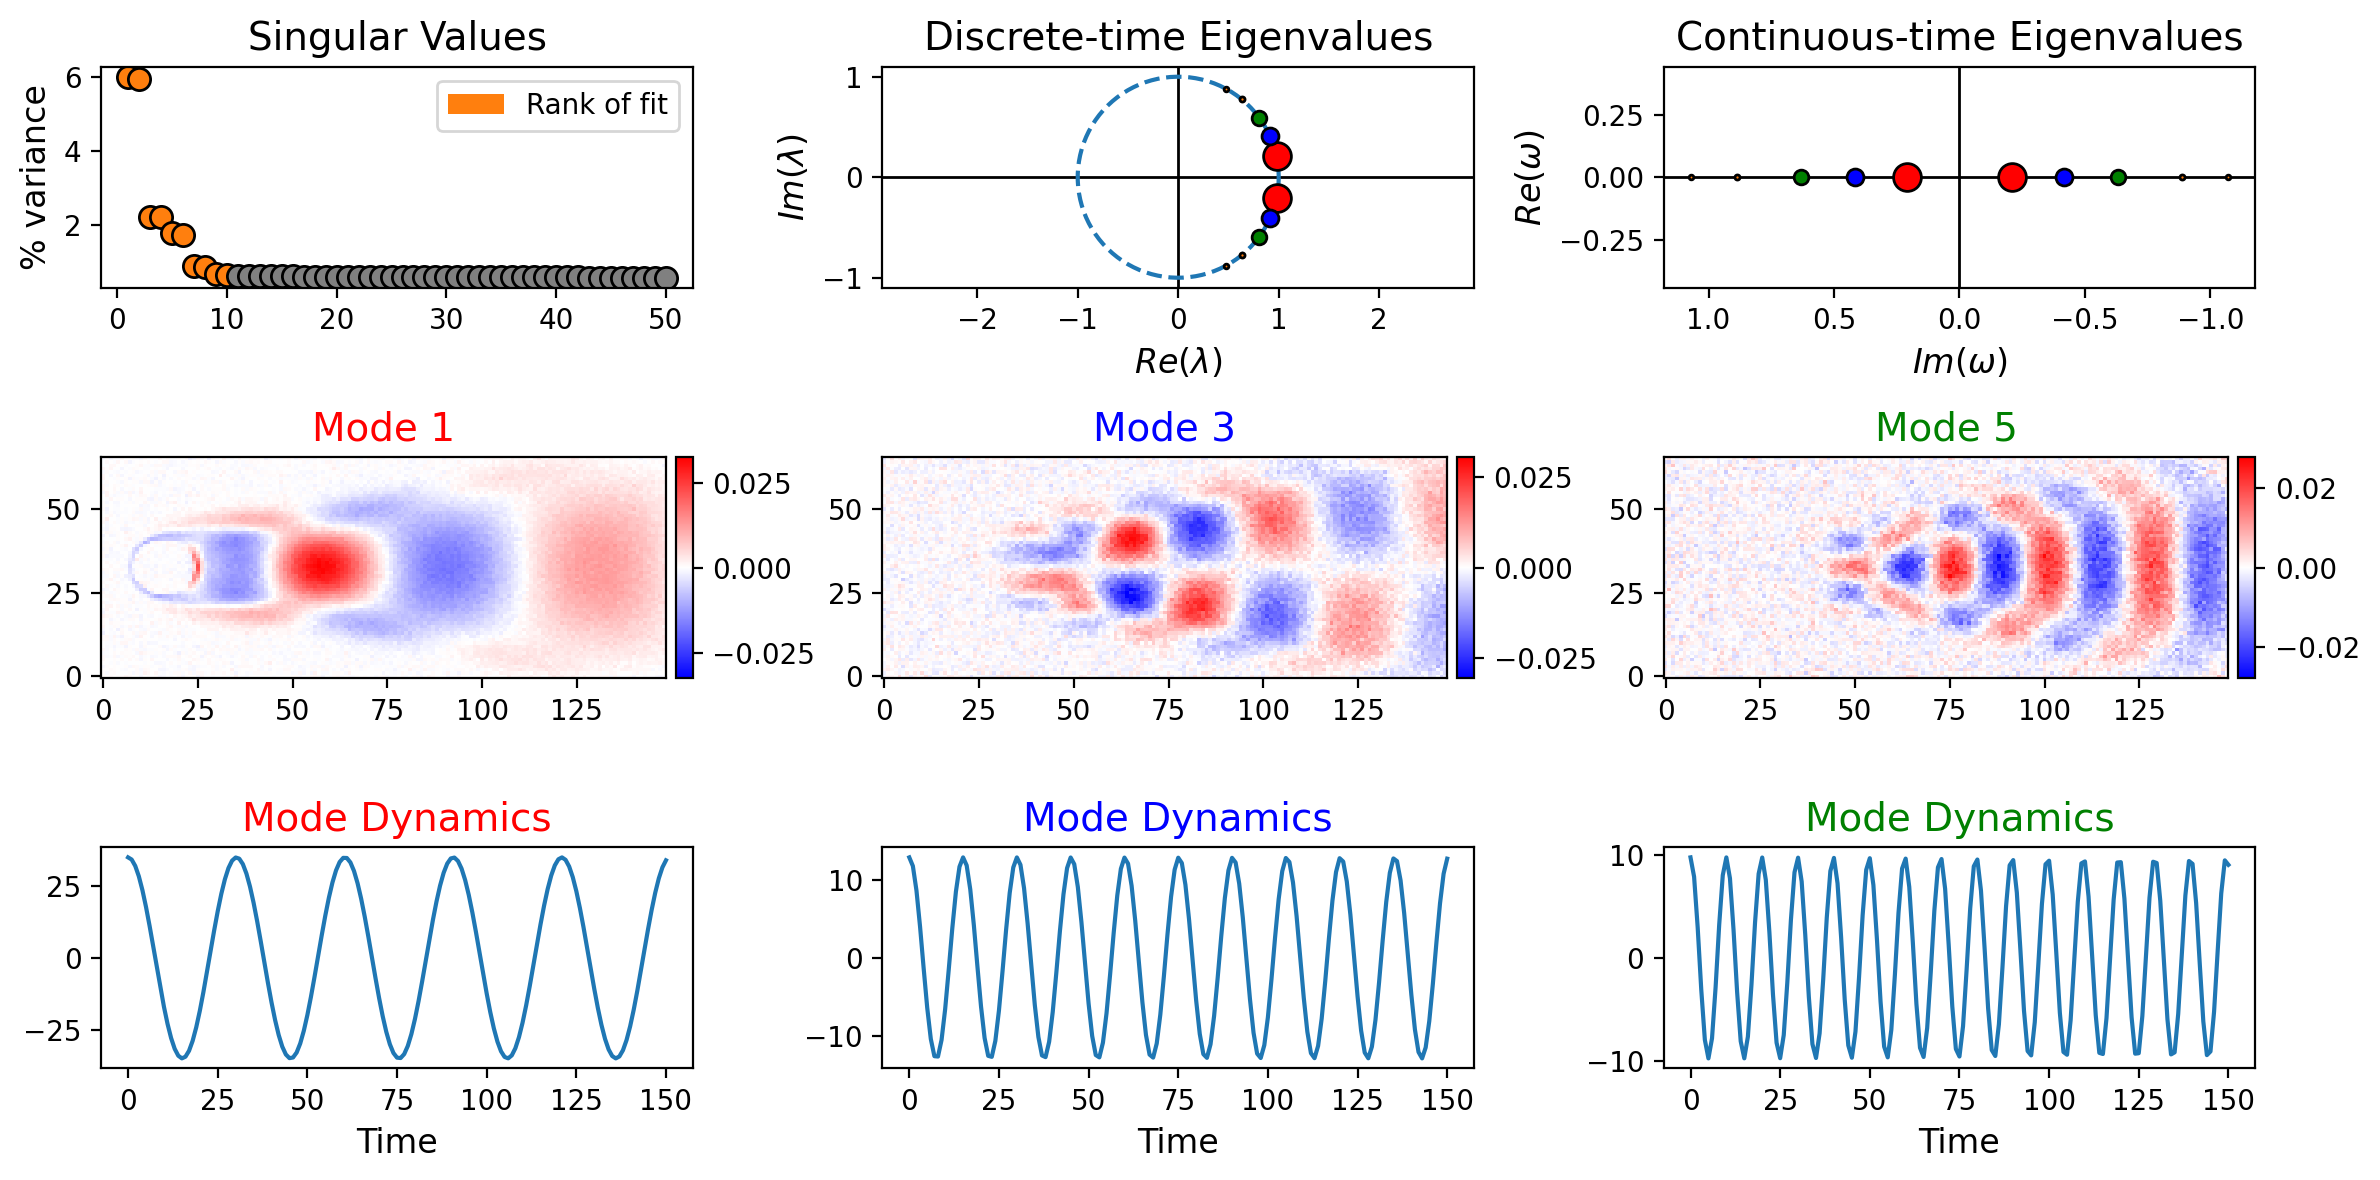

In [9]:
# BOP-DMD with zero mean centered data.
bopdmd = BOPDMD(
    svd_rank=10,  # Use an even rank due to zero mean preprocessing.
    num_trials=100,
    trial_size=0.8,
    eig_constraints={"imag", "conjugate_pairs"},
    varpro_opts_dict={"verbose": True, "tol": 0.2},
    remove_bad_bags=True,
)
bopdmd = zero_mean_preprocessing(bopdmd)
bopdmd.fit(X, t=t)

# Same plot_summary call, but plot modes 1, 3, and 5.
plot_summary_kwargs["index_modes"] = (0, 2, 4)
plot_summary(bopdmd, **plot_summary_kwargs)